This notebook entails the steps taken in predicting fraudulent transactions

The original CSV files was uploaded into SQL and using ip_address field a join was
executed to obtain the Countries of the user

Import required libraries

In [1]:
import os;

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score

set working diectory and read in the csv file

In [2]:
os.chdir('~/fraud/Fraud')
dataset = pd.read_csv('Fraud_DataII.csv')

Get datatype of variables of imported dataset

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
country           129146 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


signup_time and purchase_time are not seen as datetime variables and would have to be converted for use.
This would be done later in this notebook.
Check for imbalance in the distribution of dependent vairable

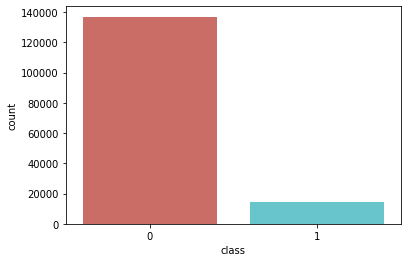

In [4]:
sns.countplot(x='class',data = dataset,palette ='hls')
plt.show()

From the chart there is an imbalance, this shall be handled later in the notebook

check for null values

In [5]:
dataset.isnull().sum()

user_id               0
signup_time           0
purchase_time         0
purchase_value        0
device_id             0
source                0
browser               0
sex                   0
age                   0
ip_address            0
class                 0
country           21966
dtype: int64

Only country has missing/null values. This missing countores would be grouped together as one as it can give us additional information.
Group the countries into smaller group using their frequencies

In [6]:
pd.value_counts(dataset.country).to_frame().reset_index()

,index,country
0,United States,58049
1,China,12038
2,Japan,7306
3,United Kingdom,4490
4,Korea Republic of,4162
...,...,...
176,Dominica,1
177,Nauru,1
178,Tajikistan,1
179,Guadeloupe,1


The United States has the highest frequency followed by CHina, Japan and United Kingdom.
Hence a grouping woul be developed

In [7]:
def country_grouping(dataset):
    if dataset['country'] == 'United States':
        val = 'United States'
    elif dataset['country'] == 'NULL':
        val = 'NULL'
    elif dataset['country'] == 'China':
        val = 'China'
    elif dataset['country'] == 'Japan':
        val = 'Japan'
    else:
        val = 'Others'
    return val

In [8]:
dataset['Country_group'] = dataset.apply(country_grouping, axis=1)

A new column 'Country_group' has now been added

Get number of unique items in each variable

In [9]:
dataset.nunique()

user_id           151112
signup_time       135572
purchase_time     121599
purchase_value       122
device_id         137956
source                 3
browser                5
sex                    2
age                   58
ip_address        143511
class                  2
country              181
Country_group          4
dtype: int64

From the above device_id and ip_address do not have unique values, which indicate repeated visit to the site. 
New features will be created which will have the aggregated count of the ip_address and device_id

In [10]:
deviceid_count=dataset.groupby('device_id',as_index=False).agg({"user_id": "count"})
ip_address_count=dataset.groupby('ip_address',as_index=False).agg({"user_id": "count"})


dataset = dataset.merge(deviceid_count, on='device_id', how='left')
dataset = dataset.rename(columns={'user_id_y': 'device_freq'})

dataset = dataset.merge(ip_address_count, on='ip_address', how='left')
dataset = dataset.rename(columns={'user_id': 'ip_address_freq'})

Check structure of dataset

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 0 to 151111
Data columns (total 15 columns):
user_id_x          151112 non-null int64
signup_time        151112 non-null object
purchase_time      151112 non-null object
purchase_value     151112 non-null int64
device_id          151112 non-null object
source             151112 non-null object
browser            151112 non-null object
sex                151112 non-null object
age                151112 non-null int64
ip_address         151112 non-null float64
class              151112 non-null int64
country            129146 non-null object
Country_group      151112 non-null object
device_freq        151112 non-null int64
ip_address_freq    151112 non-null int64
dtypes: float64(1), int64(6), object(8)
memory usage: 18.4+ MB


Drop country,ip_address,user_id as they are not useful for the final model

In [12]:
dataset = dataset.drop('user_id_x', 1)
dataset = dataset.drop('country', 1)
dataset = dataset.drop('ip_address', 1)

Convert signup_time,purchase_time to datetime

In [13]:
dataset['signup_time'] = pd.to_datetime(dataset['signup_time'], utc=True)
dataset['purchase_time'] = pd.to_datetime(dataset['purchase_time'], utc=True)

Find number of days betwen signup and purchase

In [14]:
dataset['sign_to_purch'] = (dataset['purchase_time'] - dataset['signup_time']).dt.days 

Get how long ago they signed up and made a purchase

In [15]:
from datetime import date

dataset['purchase_age'] = (date.today() - pd.to_datetime(dataset['purchase_time']).dt.date).dt.days
dataset['signup_age'] = (date.today() -  pd.to_datetime(dataset['signup_time']).dt.date).dt.days


Get distribution information on the features just created

In [16]:
print(dataset['sign_to_purch'].describe(),'\n')
print(dataset['signup_age'].describe(),'\n')
print(dataset['purchase_age'].describe(),'\n')

count    151112.000000
mean         32.716614
std         108.975735
min        -334.000000
25%         -13.000000
50%          39.000000
75%          95.000000
max         337.000000
Name: sign_to_purch, dtype: float64 

count    151112.000000
mean       1683.865649
std          88.918316
min        1483.000000
25%        1623.000000
50%        1689.000000
75%        1759.000000
max        1824.000000
Name: signup_age, dtype: float64 

count    151112.000000
mean       1650.676763
std          88.544007
min        1475.000000
25%        1583.000000
50%        1651.000000
75%        1718.000000
max        1824.000000
Name: purchase_age, dtype: float64 



The sign_to_purch variable has negative values. This need to be removed as they are invalid entries

In [17]:
indexNames = dataset[ dataset['sign_to_purch'] <0].index
 
# Delete these row indexes from dataFrame
dataset.drop(indexNames , inplace=True)
print('The number rows left is ',len(dataset))

The number rows left is  110807


Get the hour of day purchases and signups were made

In [18]:
dataset['signup_hour'] = pd.to_datetime(dataset['signup_time']).dt.hour
dataset['purchase_hour'] = pd.to_datetime(dataset['purchase_time']).dt.hour

Check variation of signup_hour and purchase_hour with class variable


Text(0, 0.5, 'Count')

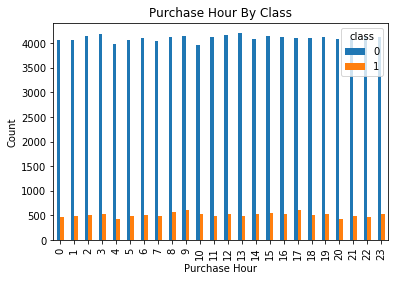

In [19]:
pd.crosstab(dataset.purchase_hour,dataset['class']).plot(kind='bar')
plt.title('Purchase Hour By Class')
plt.xlabel('Purchase Hour')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

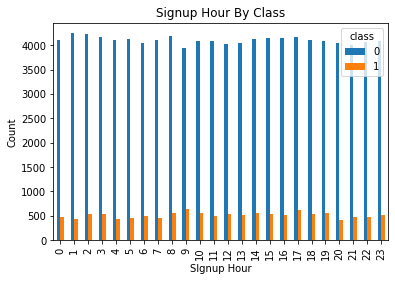

In [20]:
pd.crosstab(dataset.signup_hour,dataset['class']).plot(kind='bar')
plt.title('Signup Hour By Class')
plt.xlabel('SIgnup Hour')
plt.ylabel('Count')

There is no clear distinction between the hours and the class variable, hence both signup_hour and purchase_hour will be removed.
Also purchase_time, signup_time,device_id  will be removed as they are no longer needed

In [21]:
dataset = dataset.drop('purchase_time', 1)
dataset = dataset.drop('signup_time', 1)
dataset = dataset.drop('device_id', 1)
dataset = dataset.drop('signup_hour', 1)
dataset = dataset.drop('purchase_hour', 1)

Create dummy variables for categorical fields

In [22]:
dmmy = pd.get_dummies(dataset['source']).rename(columns=lambda x: 'Source_' + str(x))
dataset = pd.concat([dataset,dmmy],axis = 1)

dmmy = pd.get_dummies(dataset['browser']).rename(columns=lambda x: 'browser_' + str(x))
dataset = pd.concat([dataset,dmmy],axis = 1)

dmmy = pd.get_dummies(dataset['Country_group']).rename(columns=lambda x: 'Country_group_' + str(x))
dataset = pd.concat([dataset,dmmy],axis = 1)

dmmy = pd.get_dummies(dataset['sex']).rename(columns=lambda x: 'sex_' + str(x))
dataset = pd.concat([dataset,dmmy],axis = 1)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110807 entries, 0 to 151109
Data columns (total 26 columns):
purchase_value                 110807 non-null int64
source                         110807 non-null object
browser                        110807 non-null object
sex                            110807 non-null object
age                            110807 non-null int64
class                          110807 non-null int64
Country_group                  110807 non-null object
device_freq                    110807 non-null int64
ip_address_freq                110807 non-null int64
sign_to_purch                  110807 non-null int64
purchase_age                   110807 non-null int64
signup_age                     110807 non-null int64
Source_Ads                     110807 non-null uint8
Source_Direct                  110807 non-null uint8
Source_SEO                     110807 non-null uint8
browser_Chrome                 110807 non-null uint8
browser_FireFox                110807

Remove source,browser,Country_group and sex as they areno longer needed

In [23]:
dataset = dataset.drop('browser', 1)
dataset = dataset.drop('source', 1)
dataset = dataset.drop('Country_group', 1)
dataset = dataset.drop('sex', 1)

Plot correlation matrix

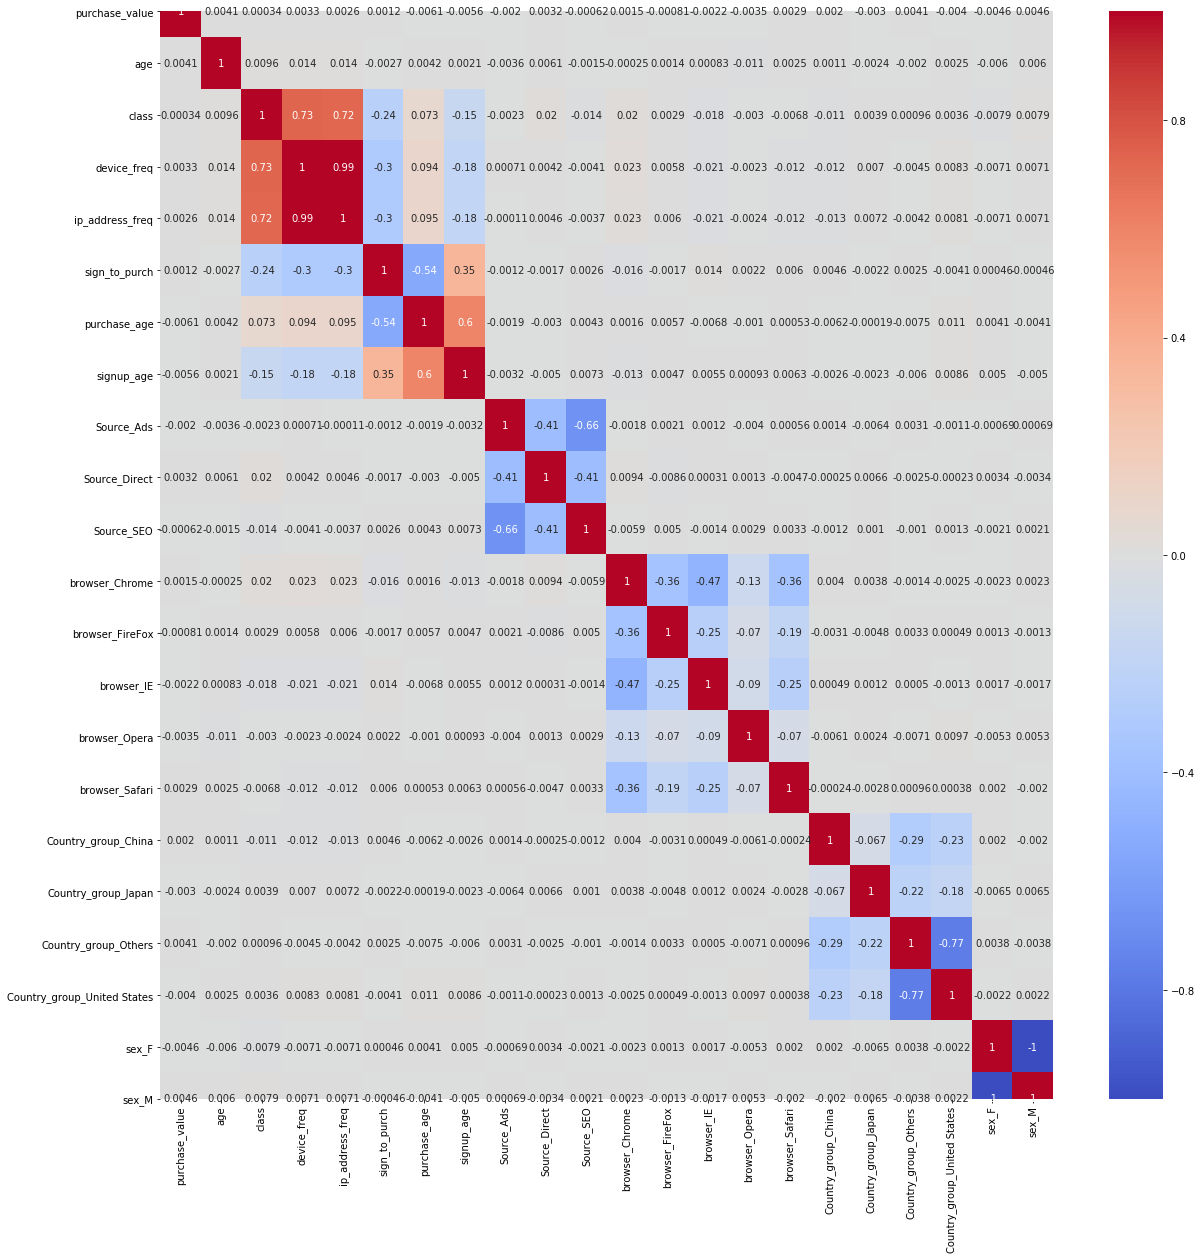

In [24]:
corr = dataset.corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr,
            vmin=-1,
            cmap='coolwarm',
            annot=True);


Remove sex_M,Country_group_United States and device_freq as they cause multi-collinearity

In [25]:
dataset = dataset.drop('sex_M', 1)
dataset = dataset.drop('Country_group_United States', 1)
dataset = dataset.drop('device_freq', 1)


Split dataset into dependent and independent variables
Split the variables into test and train and scale the independent variables

In [26]:
X = dataset.loc[:, dataset.columns != 'class']
y = dataset.loc[:, dataset.columns == 'class']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)



from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)


Using Logistics Regression, identify the most important vairables for predicting the fraud cases

In [27]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train_sc)
result=logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.250204
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.282     
Dependent Variable: class            AIC:              41618.4888
Date:               2019-12-30 18:06 BIC:              41767.7346
No. Observations:   83105            Log-Likelihood:   -20793.   
Df Model:           15               LL-Null:          -28955.   
Df Residuals:       83089            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        0.0107     0.0135     0.7923   0.4282   -0.0158    0.0372
x2       -0.0044     0.0136    -0.3278   0.7431   -0.0311 

C:\Users\kolex\Anaconda3_2\lib\site-packages\statsmodels\base\model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\kolex\Anaconda3_2\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\kolex\Anaconda3_2\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\kolex\Anaconda3_2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


using the P value, variables x3,x5,x6 will be used as their scores are less than 0.05.
Using only the columns for the final model:

In [28]:
cols = [2,4,5]
X_train_sc_f =X_train_sc[:,cols]
X_test_sc_f =X_test_sc[:,cols]

Using the ensemble voting method (models used in the ensemble are LogisticsRegression,XGBClassifier and Randomforest) as there is a data imbalance 

In [29]:
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))

from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier()
estimators.append(('RandomForest', model2))

from xgboost import XGBClassifier
model3 = XGBClassifier()
estimators.append(('XGBClassifier', model3))



Fit the model and test on test data

In [30]:
ensemble = VotingClassifier(estimators)

ensemble.fit(X_train_sc_f, y_train)

y_pred = ensemble.predict(X_test_sc_f)
print(classification_report(y_test,y_pred))

C:\Users\kolex\Anaconda3_2\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kolex\Anaconda3_2\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     24617
           1       0.99      0.63      0.77      3085

    accuracy                           0.96     27702
   macro avg       0.97      0.81      0.87     27702
weighted avg       0.96      0.96      0.95     27702



To explain the variables with most impact on detecting Fraud, we use the cols variable with the un-scaled dataset

In [31]:
X_train.iloc[:,cols]

,ip_address_freq,purchase_age,signup_age
34546,1,1667,1746
87586,1,1572,1628
57546,1,1573,1685
74574,1,1775,1776
24705,1,1566,1575
...,...,...,...
29028,1,1481,1625
62595,1,1720,1749
58108,11,1490,1490
59375,1,1532,1648


ip_address_freq


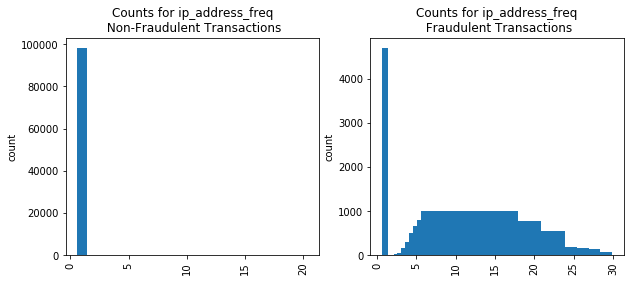

In [32]:


cat_cols = ['ip_address_freq']

dataset['dummy'] = np.ones(shape = dataset.shape[0])
for col in cat_cols:
    print(col)
    counts = dataset[['dummy', 'class', col]].groupby(['class', col], as_index = False).count()
    temp = counts[counts['class'] == 0][[col, 'dummy']]
    _ = plt.figure(figsize = (10,4))
    plt.subplot(1, 2, 1)
    temp = counts[counts['class'] == 0][[col, 'dummy']]
    plt.bar(temp[col], temp.dummy)
    plt.xticks(rotation=90)
    plt.title('Counts for ' + col + '\n Non-Fraudulent Transactions')
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    temp = counts[counts['class'] == 1][[col, 'dummy']]
    plt.bar(temp[col], temp.dummy)
    plt.xticks(rotation=90)
    plt.title('Counts for ' + col + '\n Fraudulent Transactions')
    plt.ylabel('count')
    plt.show()


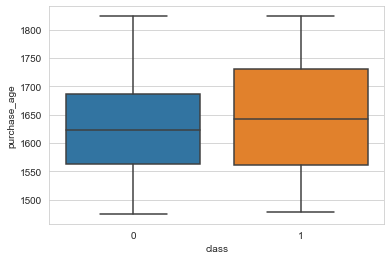

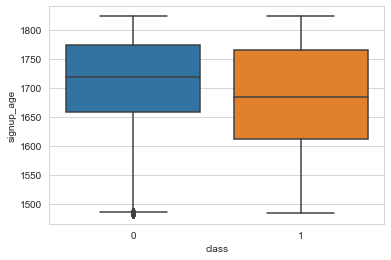

In [33]:
def plot_box(credit, cols, col_x = 'class'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.boxplot(col_x, col, data=credit)
        plt.xlabel(col_x) # Set text for the x axis
        plt.ylabel(col)# Set text for y axis
        plt.show()

num_cols = ['purchase_age','signup_age']
plot_box(dataset, num_cols)


From the Bar chart diagram above. Most non-fraudulent transactions came from unique ip-addresses, while for Fruadulent transactions there were several instances of cases occuring in repeat ip-adresses 
From the Purchase_age boxplot above, the older the purchase the more likely it is a fraud case as the mean of the fraudulent cases is higher than that of non-fruadulent cases
From the signup_age boxplot above, the older the customer the more likely it is to be a fraud case, as majority of the distribution of customers with fraudulent transactions are below the median of the customers with no fraudulent cases